Minimal example of RelaxedBernoulliStraightThrough not producing discrete samples during training.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoLowRankMultivariateNormal, AutoHierarchicalNormalMessenger, AutoNormal
from pyro.infer.autoguide.initialization import init_to_value
from pyro.infer import SVI, config_enumerate, Trace_ELBO, infer_discrete, TraceEnum_ELBO
from pyro.distributions import RelaxedBernoulliStraightThrough
RelaxedBernoulliStraightThrough.mean = property(lambda self: self.probs)

Produce some data from two Normal distributions with different means:

In [2]:
def generate_data(n_components = 2, n_observations = 100, ps = 0.9):
    
    mus = torch.tensor((4., 4.))
    binary = pyro.sample('binary',
                             RelaxedBernoulliStraightThrough(probs = ps, temperature = 0.001).expand([n_observations]).to_event(1))
                             
    mean = mus[0] + mus[1]*binary
    
    print('binary', binary)
    
    data = pyro.sample("data_target", dist.Normal(loc = mean, scale = 1.))
    
    return data

Samples are discrete during sampling:

binary tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 1., 0., 1., 1

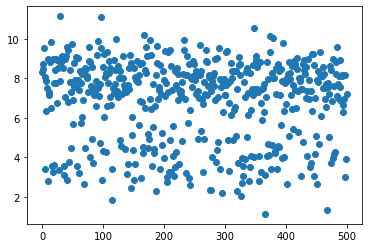

In [3]:
n_components = 2
n_observations = 500
ps = 0.75
data = generate_data(n_components, n_observations, ps)
plt.scatter(range(len(data)), data)

Our model using RelaxedBernoulliStraightThrough to assign observations to components:

In [4]:
def model_1(data, n_components, n_observations, temp = 1.):
    
    ps = pyro.sample('ps', dist.Dirichlet(torch.ones(n_components)/10.))
    mus = pyro.sample('mus', dist.Gamma(20,2).expand([n_components]).to_event(1))
    binary = pyro.sample('binary',
                             RelaxedBernoulliStraightThrough(probs = ps[0],
                                                                  temperature = torch.tensor(temp)).expand([n_observations]).to_event(1))                    
    
    print('binary', binary)
    mean = mus[0] + mus[1]*binary
    
    pyro.sample("data_target", dist.Normal(loc = mean, scale = torch.tensor(1.)).to_event(1), obs = data)

But samples are not discrete during inference or in the posterior:

In [5]:
from pyro.infer import Predictive
temperature_array = np.array((1.,  10**(-9)))
iterations_array = np.array((50, 1000))
        
global_guide = AutoHierarchicalNormalMessenger(model_1)

# Train model:
n_iterations = 1000
optim = pyro.optim.Adam({'lr': 0.1})
elbo = Trace_ELBO(max_plate_nesting=3)
svi = SVI(model_1, global_guide, optim, loss=elbo)
for i in range(n_iterations):
    loss = svi.step(data, n_components, n_observations, temp = 0.001)

posterior = Predictive(model_1, guide=global_guide, num_samples=1)(data, n_components, n_observations)


binary tensor([0.4917, 0.5321, 0.4808, 0.5069, 0.5530, 0.4873, 0.5073, 0.4951, 0.4863,
        0.5250, 0.4638, 0.5244, 0.4809, 0.4998, 0.4908, 0.4965, 0.4791, 0.4972,
        0.4907, 0.5808, 0.5340, 0.5790, 0.5176, 0.5046, 0.4837, 0.5118, 0.5030,
        0.5010, 0.5059, 0.5168, 0.4822, 0.4921, 0.5268, 0.4447, 0.5219, 0.5590,
        0.5020, 0.4874, 0.5075, 0.5018, 0.5339, 0.5157, 0.5055, 0.5037, 0.4831,
        0.4804, 0.4865, 0.5279, 0.5109, 0.5060, 0.5162, 0.4995, 0.4890, 0.4928,
        0.5082, 0.4824, 0.4762, 0.5346, 0.5150, 0.5226, 0.5775, 0.4673, 0.4789,
        0.5310, 0.5080, 0.4931, 0.5267, 0.4943, 0.5012, 0.5329, 0.4940, 0.5149,
        0.5114, 0.5624, 0.5648, 0.5295, 0.5331, 0.5361, 0.5172, 0.4973, 0.4952,
        0.5077, 0.4599, 0.4578, 0.4988, 0.4898, 0.5357, 0.5037, 0.5021, 0.5471,
        0.5213, 0.4738, 0.4737, 0.5143, 0.5204, 0.5197, 0.5400, 0.5425, 0.4929,
        0.5348, 0.4946, 0.5203, 0.5044, 0.5015, 0.4509, 0.5151, 0.4682, 0.5332,
        0.5055, 0.5045, 0.4524, 0

binary tensor([0.3842, 0.3811, 0.3165, 0.3305, 0.3057, 0.3255, 0.3248, 0.2547, 0.2533,
        0.3156, 0.3302, 0.3324, 0.3447, 0.3805, 0.3890, 0.3321, 0.3513, 0.2817,
        0.3461, 0.3407, 0.2986, 0.3228, 0.3264, 0.3158, 0.3118, 0.3111, 0.3009,
        0.3200, 0.2907, 0.3554, 0.3349, 0.4327, 0.3752, 0.3659, 0.4040, 0.2957,
        0.3554, 0.2934, 0.3678, 0.3873, 0.3689, 0.2819, 0.3952, 0.3150, 0.2869,
        0.3399, 0.2997, 0.3196, 0.2665, 0.3389, 0.3820, 0.3265, 0.3795, 0.2621,
        0.3361, 0.4066, 0.3485, 0.2878, 0.3223, 0.3351, 0.3131, 0.3350, 0.3455,
        0.3372, 0.2558, 0.2818, 0.3154, 0.3181, 0.3885, 0.3209, 0.3075, 0.3093,
        0.3578, 0.3225, 0.3298, 0.3618, 0.3262, 0.3484, 0.3212, 0.2748, 0.3046,
        0.2822, 0.3377, 0.3146, 0.3445, 0.3487, 0.3246, 0.3371, 0.2784, 0.3228,
        0.3760, 0.3704, 0.3144, 0.2971, 0.2996, 0.3028, 0.3756, 0.4091, 0.3150,
        0.3239, 0.3782, 0.3063, 0.3856, 0.3671, 0.3680, 0.2905, 0.3457, 0.3051,
        0.4242, 0.3088, 0.3618, 0

binary tensor([0.7292, 0.6284, 0.3431, 0.7627, 0.2082, 0.4180, 0.6741, 0.3582, 0.7918,
        0.1484, 0.5981, 0.3102, 0.2976, 0.7019, 0.7746, 0.4675, 0.1304, 0.1459,
        0.5901, 0.5114, 0.2206, 0.5495, 0.6035, 0.7340, 0.6751, 0.4925, 0.3860,
        0.5541, 0.3889, 0.8082, 0.6890, 0.6585, 0.6870, 0.6014, 0.6097, 0.1641,
        0.1201, 0.2004, 0.2252, 0.6353, 0.6382, 0.2569, 0.7893, 0.3801, 0.1534,
        0.3313, 0.3669, 0.1662, 0.5590, 0.7570, 0.5766, 0.3987, 0.7838, 0.6077,
        0.5605, 0.7416, 0.5130, 0.1594, 0.7759, 0.3185, 0.1849, 0.2833, 0.5449,
        0.4675, 0.7138, 0.6101, 0.7200, 0.2122, 0.7856, 0.1142, 0.7552, 0.2583,
        0.6741, 0.4513, 0.3443, 0.4370, 0.4465, 0.7401, 0.8433, 0.2480, 0.3465,
        0.1580, 0.6220, 0.1726, 0.2682, 0.3774, 0.4414, 0.7212, 0.1554, 0.6559,
        0.6067, 0.5980, 0.2315, 0.3812, 0.2819, 0.3911, 0.6935, 0.7452, 0.1449,
        0.3392, 0.2309, 0.1366, 0.3778, 0.3013, 0.7045, 0.4147, 0.4847, 0.2048,
        0.5080, 0.3623, 0.5805, 0

binary tensor([0.6017, 0.7542, 0.7686, 0.9218, 0.2840, 0.1402, 0.5717, 0.4995, 0.6589,
        0.1853, 0.5841, 0.5986, 0.1634, 0.5439, 0.1747, 0.7937, 0.3873, 0.0867,
        0.5196, 0.5756, 0.3032, 0.5640, 0.7350, 0.7523, 0.6785, 0.5947, 0.6640,
        0.4277, 0.4145, 0.4232, 0.7436, 0.5818, 0.4987, 0.7417, 0.3192, 0.2272,
        0.5392, 0.2755, 0.8931, 0.4585, 0.6816, 0.1300, 0.8679, 0.3921, 0.2632,
        0.6493, 0.8499, 0.1948, 0.3804, 0.6516, 0.2693, 0.3894, 0.7260, 0.8882,
        0.3423, 0.7303, 0.4575, 0.1792, 0.5749, 0.8895, 0.2193, 0.5137, 0.6115,
        0.3266, 0.3261, 0.3693, 0.6146, 0.7059, 0.2274, 0.1659, 0.7110, 0.3079,
        0.6450, 0.5392, 0.5792, 0.3604, 0.6244, 0.9040, 0.9012, 0.2110, 0.6828,
        0.6648, 0.7324, 0.3153, 0.8393, 0.3530, 0.4334, 0.2104, 0.4819, 0.5477,
        0.6802, 0.6578, 0.6673, 0.3567, 0.4001, 0.5296, 0.7254, 0.7560, 0.1606,
        0.3241, 0.4962, 0.3165, 0.5117, 0.6328, 0.8057, 0.5729, 0.5428, 0.4006,
        0.7244, 0.7023, 0.7367, 0

binary tensor([3.9532e-01, 7.4947e-01, 9.4707e-01, 9.7972e-01, 5.3426e-03, 8.7753e-01,
        9.0589e-01, 2.4009e-02, 5.9323e-01, 1.7058e-06, 5.6399e-01, 7.4103e-01,
        9.9704e-01, 4.9193e-01, 2.9511e-04, 5.5607e-01, 1.2217e-03, 2.4248e-04,
        9.6978e-01, 7.1137e-01, 2.0214e-03, 4.0964e-01, 9.5024e-01, 1.6141e-01,
        6.2553e-01, 1.4351e-02, 9.9168e-01, 2.2498e-03, 9.9822e-04, 4.8474e-02,
        8.5870e-01, 8.3260e-01, 9.4655e-01, 5.9376e-02, 9.9503e-01, 1.6863e-03,
        1.7874e-02, 8.1856e-01, 6.8381e-01, 3.2378e-01, 9.0305e-01, 6.0132e-05,
        9.3237e-01, 2.0075e-03, 3.0987e-02, 7.0688e-01, 6.1688e-01, 4.3732e-02,
        5.7928e-01, 9.3151e-01, 5.5981e-01, 1.6465e-02, 6.7416e-01, 1.8389e-02,
        8.4988e-01, 9.0636e-01, 2.9934e-02, 8.1154e-06, 9.6358e-01, 5.5965e-01,
        5.5849e-04, 9.7394e-01, 6.4945e-01, 9.2554e-01, 9.7109e-01, 8.2815e-01,
        8.5172e-01, 5.0194e-01, 7.2326e-01, 9.2667e-06, 4.7823e-01, 2.7368e-02,
        8.3499e-01, 3.3773e-01, 7

binary tensor([9.4838e-01, 9.9229e-01, 9.4588e-01, 8.9347e-01, 7.2183e-01, 9.6764e-01,
        4.2266e-01, 6.9813e-10, 9.5694e-01, 4.5755e-11, 5.9368e-01, 1.8903e-05,
        9.5185e-03, 9.5726e-01, 3.9782e-01, 9.5396e-01, 2.7068e-04, 1.7098e-06,
        1.1942e-01, 1.0744e-01, 4.1168e-04, 9.4706e-01, 8.9885e-01, 1.5176e-01,
        5.4631e-01, 1.2228e-02, 8.1563e-01, 9.5976e-01, 5.5324e-04, 9.3805e-01,
        9.5335e-01, 9.8462e-01, 9.7490e-01, 4.6762e-01, 8.6568e-01, 1.4651e-07,
        2.3046e-06, 9.5827e-01, 9.9561e-01, 9.7460e-01, 9.5517e-01, 1.8702e-06,
        8.9998e-01, 6.0417e-01, 2.2517e-09, 9.0082e-01, 1.3452e-01, 3.3835e-05,
        7.7318e-01, 8.5997e-01, 3.9026e-01, 3.4572e-02, 6.9663e-01, 9.9834e-01,
        6.4545e-01, 9.4937e-01, 9.3926e-01, 2.1529e-11, 9.5985e-01, 7.5402e-01,
        2.4052e-06, 2.5808e-01, 8.4351e-01, 1.5300e-03, 8.0010e-02, 1.8408e-01,
        1.0044e-01, 9.6185e-01, 3.4776e-01, 8.1032e-10, 8.5413e-01, 1.6350e-01,
        3.4338e-01, 9.3063e-01, 7

binary tensor([1.2487e-01, 7.4819e-01, 9.8547e-01, 9.5649e-01, 2.4956e-11, 1.0995e-01,
        4.6676e-01, 1.5134e-04, 9.5689e-01, 1.1341e-14, 9.3525e-01, 5.2952e-01,
        9.9967e-01, 7.5495e-01, 9.9998e-01, 8.9281e-01, 1.0021e-05, 3.3059e-19,
        9.5780e-01, 9.6819e-01, 9.9649e-01, 9.3350e-01, 9.9874e-01, 2.9593e-01,
        6.9625e-01, 2.8658e-04, 3.3872e-01, 4.3560e-01, 1.9170e-08, 7.7987e-01,
        9.9457e-01, 4.8331e-02, 9.3873e-01, 9.9820e-01, 9.7794e-01, 1.3885e-17,
        6.1367e-12, 8.8786e-06, 9.1858e-01, 8.8123e-01, 9.3455e-01, 3.0480e-15,
        8.1907e-02, 9.9972e-01, 5.9749e-10, 9.6199e-01, 9.9995e-01, 7.6209e-14,
        1.2456e-02, 9.9843e-01, 9.9958e-01, 1.6263e-03, 7.2957e-01, 4.0388e-01,
        9.9544e-01, 9.4572e-01, 9.9768e-01, 7.5887e-06, 9.9152e-01, 9.8339e-01,
        3.0076e-14, 5.2375e-02, 3.7313e-01, 6.1047e-01, 1.6238e-01, 2.7159e-01,
        5.4672e-01, 9.3706e-01, 8.5368e-01, 1.3302e-16, 4.0454e-01, 7.9204e-18,
        1.4853e-01, 6.1517e-01, 8

binary tensor([9.9975e-01, 9.9300e-01, 9.6310e-01, 6.9396e-01, 9.9843e-01, 9.8378e-01,
        1.3407e-02, 8.3595e-02, 9.9995e-01, 2.3706e-29, 9.8736e-01, 3.3020e-01,
        2.7838e-02, 8.6149e-01, 8.2275e-03, 9.8106e-01, 9.7909e-20, 3.4217e-31,
        8.2238e-01, 6.6397e-03, 2.3064e-10, 7.6452e-01, 8.8742e-01, 1.4373e-01,
        9.8262e-01, 1.0000e+00, 9.2509e-01, 7.6607e-01, 1.4102e-07, 9.8838e-01,
        9.9980e-01, 9.7750e-01, 7.8041e-01, 9.9896e-01, 9.9511e-01, 8.1245e-12,
        1.1607e-13, 9.9971e-01, 9.9719e-01, 1.6238e-03, 9.8583e-01, 1.1766e-17,
        9.8206e-01, 3.5545e-05, 3.1616e-16, 9.6190e-01, 9.1456e-01, 1.9555e-15,
        2.7437e-08, 9.9085e-01, 2.6472e-01, 4.6400e-02, 7.7659e-01, 1.0000e+00,
        9.5945e-01, 9.8189e-01, 9.9886e-01, 8.0525e-07, 9.8176e-01, 1.4165e-01,
        4.4363e-27, 1.1507e-01, 9.9712e-01, 9.9868e-01, 3.7140e-03, 6.8355e-01,
        9.9874e-01, 1.0000e+00, 9.4988e-01, 5.2906e-18, 4.0907e-04, 5.8836e-13,
        9.6266e-01, 3.3947e-04, 9

binary tensor([9.9973e-01, 9.9998e-01, 2.1474e-01, 9.9968e-01, 2.8622e-11, 9.4659e-01,
        9.9892e-01, 9.9098e-01, 1.3495e-03, 1.1749e-08, 6.1707e-01, 3.3821e-01,
        8.9800e-01, 7.6193e-01, 6.2599e-06, 9.0537e-01, 8.5558e-20, 2.2644e-10,
        6.7656e-01, 5.9703e-01, 2.8304e-12, 9.9952e-01, 9.9788e-01, 9.2635e-01,
        9.7048e-01, 2.9267e-03, 3.8463e-02, 5.0802e-01, 1.2713e-16, 9.9996e-01,
        9.9680e-01, 9.0007e-01, 9.9757e-01, 8.3207e-01, 9.0564e-01, 8.9722e-09,
        8.8880e-08, 1.1848e-02, 9.6067e-01, 7.4048e-01, 9.9992e-01, 2.3016e-19,
        9.8081e-01, 2.0274e-01, 2.4456e-11, 9.9346e-01, 9.9996e-01, 3.8855e-27,
        9.9998e-01, 9.9869e-01, 1.2203e-06, 3.5348e-11, 9.8700e-01, 9.9753e-01,
        9.0144e-01, 4.0426e-01, 9.9602e-01, 4.2648e-25, 9.9534e-01, 9.9781e-01,
        9.9671e-01, 1.5144e-01, 4.9801e-03, 9.8676e-01, 2.7833e-08, 2.5954e-04,
        9.1396e-01, 1.8807e-04, 9.9428e-01, 3.7128e-27, 1.7633e-02, 4.7818e-12,
        6.3824e-02, 9.0508e-01, 9

binary tensor([2.3822e-01, 4.4826e-01, 9.9948e-01, 9.7862e-01, 2.4682e-15, 9.9751e-01,
        6.5156e-04, 6.2565e-04, 9.9834e-01, 2.0702e-21, 9.0574e-01, 3.3352e-01,
        9.9991e-01, 9.9414e-01, 3.4051e-06, 8.4926e-01, 1.9360e-13, 3.6737e-11,
        9.9490e-01, 4.2399e-01, 8.8791e-11, 1.4503e-06, 9.7785e-01, 6.5995e-02,
        9.5383e-01, 2.8394e-05, 7.0363e-05, 9.7229e-01, 1.5072e-22, 7.0254e-05,
        9.9784e-01, 9.8948e-01, 9.3157e-01, 9.2697e-01, 8.8526e-01, 5.8127e-18,
        1.4743e-12, 1.8760e-01, 9.7967e-01, 6.9748e-01, 9.6079e-01, 9.9162e-13,
        9.7039e-01, 1.4122e-02, 1.0742e-14, 9.9526e-01, 6.9919e-01, 9.9936e-01,
        9.9998e-01, 9.9851e-01, 3.6765e-05, 5.1415e-11, 9.8624e-01, 9.9848e-01,
        5.5255e-01, 9.8706e-01, 3.6882e-01, 1.5494e-26, 9.9326e-01, 1.8359e-05,
        5.9279e-17, 9.9797e-01, 9.8703e-01, 9.9928e-01, 1.2541e-20, 5.0688e-10,
        8.1083e-01, 2.4920e-03, 2.5797e-04, 1.3432e-24, 9.7328e-01, 1.4174e-01,
        7.6508e-01, 2.3416e-02, 8

binary tensor([9.9702e-01, 8.3244e-01, 9.9400e-01, 9.6528e-01, 3.3730e-09, 9.7072e-01,
        6.0181e-01, 3.0657e-01, 1.4768e-01, 1.2566e-22, 9.8809e-01, 4.0780e-01,
        9.9999e-01, 2.4883e-01, 5.8961e-01, 9.8459e-01, 2.3564e-18, 3.4162e-05,
        7.3803e-01, 7.9666e-02, 4.5455e-23, 9.7499e-01, 9.8997e-01, 5.9853e-01,
        9.6201e-01, 3.9849e-05, 7.4620e-01, 9.4944e-01, 1.0246e-27, 5.8771e-01,
        9.3688e-01, 9.9714e-01, 9.9877e-01, 9.9285e-01, 1.3861e-01, 2.9115e-14,
        1.3361e-11, 9.8646e-01, 9.9543e-01, 9.9934e-01, 9.9863e-01, 2.3263e-18,
        7.1525e-01, 9.9725e-01, 4.7022e-13, 9.9070e-01, 1.1688e-01, 8.9379e-16,
        7.0473e-01, 9.9673e-01, 2.8839e-07, 1.5217e-20, 9.8746e-01, 9.3334e-04,
        6.7247e-02, 8.1253e-01, 4.4800e-01, 3.3098e-23, 9.7223e-01, 1.0000e+00,
        9.0366e-05, 9.3066e-05, 9.6781e-01, 9.9718e-01, 1.4084e-09, 7.5434e-02,
        9.9943e-01, 1.0000e+00, 9.1690e-01, 1.6701e-17, 8.0819e-01, 1.0150e-09,
        9.9794e-01, 9.5840e-01, 4

binary tensor([8.3929e-01, 9.7623e-01, 9.9741e-01, 9.8933e-01, 9.0466e-08, 1.8917e-01,
        4.4522e-01, 3.3048e-07, 9.7700e-01, 6.6590e-21, 9.5657e-01, 9.9995e-01,
        6.4293e-03, 9.9921e-01, 9.9995e-01, 9.8374e-01, 9.0077e-27, 2.5735e-02,
        9.7913e-01, 5.9851e-10, 4.9166e-07, 6.4732e-01, 9.9998e-01, 9.9249e-01,
        9.9982e-01, 5.7634e-01, 9.6627e-01, 8.1058e-01, 1.6324e-24, 9.8594e-01,
        9.9674e-01, 7.2878e-01, 9.9927e-01, 9.9857e-01, 8.3562e-01, 8.2394e-18,
        1.5108e-10, 2.0519e-05, 9.8387e-01, 9.7254e-01, 1.8633e-02, 1.3772e-22,
        9.9949e-01, 5.0869e-07, 5.1899e-27, 9.9895e-01, 7.6928e-02, 5.6043e-16,
        6.2328e-03, 9.9955e-01, 3.7381e-05, 1.5277e-13, 9.8782e-01, 9.9341e-01,
        9.9998e-01, 9.9986e-01, 9.9990e-01, 1.4528e-13, 9.9206e-01, 9.2462e-01,
        1.0330e-19, 9.9999e-01, 6.6655e-01, 1.2384e-05, 4.5109e-03, 6.2790e-06,
        9.9993e-01, 9.9993e-01, 9.8466e-01, 1.8414e-23, 9.9983e-01, 8.0718e-14,
        9.9985e-01, 9.5472e-01, 8

binary tensor([9.7733e-01, 3.8573e-01, 9.9892e-01, 9.9999e-01, 2.5133e-23, 9.7310e-01,
        9.3440e-02, 1.7264e-04, 9.9481e-05, 2.3249e-24, 9.9086e-01, 9.6590e-01,
        8.8165e-03, 9.6221e-01, 2.1769e-07, 9.9660e-01, 7.3842e-11, 3.3294e-16,
        9.9558e-01, 1.9978e-01, 2.0384e-10, 7.8469e-01, 9.9939e-01, 9.8853e-01,
        8.4014e-01, 5.9670e-04, 9.9694e-01, 9.9169e-01, 3.4886e-11, 1.3010e-01,
        1.0000e+00, 9.9885e-01, 9.8452e-01, 9.7417e-01, 3.3506e-01, 5.4997e-27,
        1.0341e-21, 9.2164e-01, 9.4112e-01, 9.9996e-01, 9.9126e-01, 1.5030e-23,
        9.9965e-01, 8.8022e-03, 5.8498e-15, 9.9998e-01, 9.9987e-01, 2.5371e-22,
        9.8325e-01, 9.7301e-01, 9.1042e-04, 1.2081e-19, 9.9689e-01, 9.7613e-01,
        9.9966e-01, 7.5538e-01, 9.7423e-01, 1.7700e-13, 9.9962e-01, 9.8363e-01,
        1.1755e-38, 5.1040e-02, 9.1270e-01, 4.9413e-01, 5.8724e-23, 6.8734e-10,
        9.2821e-01, 1.4628e-05, 1.0000e+00, 2.4800e-22, 9.9947e-01, 1.1400e-24,
        1.0000e+00, 9.9995e-01, 9

binary tensor([6.7368e-01, 9.8946e-01, 9.9720e-01, 9.9811e-01, 1.0944e-33, 4.4141e-02,
        6.3548e-01, 1.0537e-01, 9.9681e-01, 2.1989e-12, 4.6236e-01, 9.9512e-01,
        9.9653e-01, 9.9986e-01, 1.3852e-02, 9.3764e-01, 5.5473e-22, 4.6828e-18,
        8.8168e-01, 8.3969e-01, 1.0000e+00, 9.5810e-01, 9.9982e-01, 1.0553e-01,
        9.9945e-01, 1.6152e-01, 9.5983e-01, 9.5620e-01, 4.2841e-18, 8.9888e-01,
        9.9555e-01, 9.9781e-01, 9.9188e-01, 9.9991e-01, 1.0000e+00, 2.3153e-18,
        3.6126e-36, 1.0000e+00, 9.9982e-01, 9.8295e-01, 9.5934e-01, 9.4547e-24,
        9.9345e-01, 3.0075e-04, 1.2436e-18, 9.9999e-01, 8.4506e-01, 1.4007e-10,
        5.7593e-03, 9.9719e-01, 7.9650e-02, 7.0227e-31, 9.8093e-01, 9.8027e-01,
        1.0000e+00, 9.9998e-01, 4.9638e-02, 2.3727e-36, 2.3208e-01, 9.9936e-01,
        3.1395e-02, 3.7745e-02, 9.3825e-01, 8.0954e-01, 3.8432e-22, 1.0000e+00,
        9.9996e-01, 9.2239e-01, 9.9461e-01, 1.2913e-22, 9.9883e-01, 2.6555e-30,
        9.9843e-01, 6.9238e-01, 9

binary tensor([1.0000e+00, 9.5573e-01, 9.9998e-01, 9.9984e-01, 5.8984e-12, 9.3995e-01,
        9.9415e-01, 8.8909e-01, 8.7556e-01, 2.1953e-36, 9.5617e-01, 1.0000e+00,
        9.7891e-01, 9.5319e-01, 5.3655e-03, 9.9958e-01, 3.2679e-16, 8.7890e-15,
        9.7174e-01, 1.2650e-02, 1.0494e-12, 9.9987e-01, 9.9894e-01, 4.8299e-02,
        9.9876e-01, 9.1118e-01, 9.5844e-01, 9.9939e-01, 2.0755e-18, 8.8533e-01,
        9.9852e-01, 9.9743e-01, 9.8749e-01, 9.3266e-01, 9.9995e-01, 8.4533e-24,
        2.7629e-28, 1.0000e+00, 9.9990e-01, 9.9995e-01, 9.9992e-01, 1.4012e-10,
        9.9990e-01, 4.4505e-01, 4.9181e-14, 9.2731e-01, 9.9993e-01, 1.6424e-21,
        1.8385e-05, 9.9701e-01, 6.4402e-02, 1.8073e-10, 9.9930e-01, 9.8040e-01,
        9.9935e-01, 9.9989e-01, 7.5404e-02, 1.2078e-31, 9.8556e-01, 9.1341e-01,
        8.0983e-17, 9.9986e-01, 9.7039e-01, 8.0771e-01, 7.9552e-18, 6.9832e-03,
        9.9089e-01, 9.9911e-01, 9.9991e-01, 5.4998e-22, 9.2182e-01, 1.3590e-13,
        8.3668e-01, 6.4601e-01, 9

binary tensor([9.9335e-01, 9.9999e-01, 1.0000e+00, 9.9991e-01, 4.6012e-17, 9.9835e-01,
        5.0356e-01, 1.0495e-01, 2.0059e-01, 2.0624e-31, 9.9995e-01, 7.3257e-01,
        9.9995e-01, 9.9900e-01, 9.6498e-02, 9.9681e-01, 8.4966e-24, 3.5400e-09,
        5.3977e-01, 4.4334e-01, 1.6975e-10, 9.9764e-01, 9.9999e-01, 9.9817e-01,
        9.9250e-01, 3.1000e-04, 3.8153e-02, 9.9535e-01, 1.3891e-16, 9.1260e-01,
        9.9871e-01, 8.8357e-01, 9.9839e-01, 8.7034e-01, 9.9448e-01, 6.5070e-10,
        1.3069e-12, 7.1410e-02, 9.9816e-01, 9.9999e-01, 6.2042e-01, 3.1871e-35,
        1.0000e+00, 9.9645e-01, 1.6695e-30, 9.9913e-01, 1.8701e-06, 2.4944e-23,
        3.6855e-06, 9.9860e-01, 3.9550e-05, 1.6348e-11, 9.9900e-01, 4.0761e-05,
        2.9280e-01, 9.6152e-01, 9.9998e-01, 5.2483e-06, 9.9894e-01, 9.9998e-01,
        6.6727e-18, 9.9975e-01, 9.7554e-01, 2.1752e-05, 6.6318e-14, 6.3776e-05,
        9.9996e-01, 2.9027e-04, 8.8728e-01, 1.1380e-04, 9.9991e-01, 2.3768e-27,
        9.9922e-01, 8.4068e-01, 9

binary tensor([9.9996e-01, 5.3196e-01, 9.5825e-01, 9.9989e-01, 1.1755e-38, 9.8640e-01,
        9.9945e-01, 7.4274e-05, 9.8974e-01, 2.4123e-09, 1.0000e+00, 9.0877e-01,
        9.8786e-01, 9.9942e-01, 9.9859e-01, 9.9942e-01, 1.1956e-28, 1.4163e-21,
        9.9965e-01, 9.8645e-01, 2.7758e-22, 7.1328e-01, 9.9912e-01, 4.5990e-03,
        9.9996e-01, 9.6104e-01, 9.9939e-01, 9.9937e-01, 2.1235e-26, 9.3922e-01,
        9.9998e-01, 7.8296e-01, 9.9926e-01, 9.9993e-01, 9.8636e-01, 1.6632e-20,
        2.1856e-12, 1.3738e-01, 9.9793e-01, 9.9993e-01, 9.9995e-01, 3.5021e-17,
        9.9961e-01, 9.7479e-01, 1.1755e-38, 9.9993e-01, 9.9582e-01, 7.5684e-22,
        9.4370e-06, 9.9965e-01, 6.3218e-02, 2.3529e-13, 9.1483e-02, 1.3148e-01,
        9.9999e-01, 8.7673e-01, 1.6390e-03, 1.9587e-16, 9.9867e-01, 9.8371e-01,
        2.1051e-20, 2.5203e-01, 9.9995e-01, 9.5818e-01, 1.5863e-15, 1.0592e-12,
        2.7595e-01, 5.7147e-06, 8.2137e-01, 1.3762e-30, 9.8716e-01, 2.7381e-31,
        9.9059e-01, 8.6951e-01, 9

binary tensor([1.0144e-01, 9.9993e-01, 9.9629e-01, 1.0000e+00, 9.8525e-21, 9.9736e-01,
        6.1644e-02, 1.8558e-07, 8.7158e-01, 1.9402e-04, 9.9999e-01, 9.7387e-01,
        9.8163e-01, 9.9992e-01, 9.9906e-01, 1.0000e+00, 4.1375e-08, 2.8577e-01,
        9.9997e-01, 7.4468e-01, 5.4015e-10, 9.9279e-01, 9.9963e-01, 9.8367e-01,
        3.0245e-01, 1.8181e-01, 6.6542e-03, 9.9973e-01, 4.8940e-14, 9.9949e-01,
        9.8300e-01, 9.9562e-01, 1.0000e+00, 9.9958e-01, 9.9826e-01, 7.3458e-26,
        1.7749e-13, 5.8997e-03, 9.9982e-01, 9.9991e-01, 9.9998e-01, 3.3712e-08,
        9.9833e-01, 1.5155e-05, 9.9878e-01, 9.9998e-01, 7.2081e-01, 8.6080e-11,
        8.0516e-01, 9.9999e-01, 9.9961e-01, 3.6640e-06, 1.0000e+00, 1.4852e-06,
        1.0000e+00, 7.4769e-01, 9.6678e-01, 1.8527e-09, 9.9902e-01, 9.7911e-01,
        1.6386e-21, 9.7071e-01, 9.8862e-01, 8.7503e-01, 9.5944e-06, 4.1673e-03,
        9.9983e-01, 9.9737e-01, 9.5597e-01, 1.5895e-14, 9.9957e-01, 1.1064e-21,
        9.9921e-01, 9.9892e-01, 5

binary tensor([1.0000e+00, 9.9963e-01, 9.9986e-01, 9.9992e-01, 3.8409e-13, 1.0000e+00,
        9.7338e-01, 7.9347e-11, 4.7596e-01, 1.3225e-09, 1.0000e+00, 9.8579e-01,
        9.3442e-05, 9.9672e-01, 9.5070e-03, 9.9995e-01, 1.8991e-09, 1.2754e-28,
        9.9620e-01, 7.1711e-01, 6.9246e-34, 9.9918e-01, 1.0000e+00, 9.9997e-01,
        9.9975e-01, 7.4619e-01, 5.8032e-01, 9.9981e-01, 1.1604e-18, 9.9984e-01,
        9.9999e-01, 9.9799e-01, 9.9969e-01, 9.9993e-01, 9.9434e-01, 3.5627e-11,
        2.8913e-30, 9.7779e-01, 9.9988e-01, 9.9989e-01, 9.9999e-01, 6.7159e-24,
        9.9735e-01, 8.2325e-01, 9.8275e-13, 9.9775e-01, 8.7558e-01, 1.6643e-13,
        1.3149e-01, 9.9999e-01, 9.9991e-01, 1.2910e-07, 9.8562e-01, 9.7801e-01,
        9.8817e-01, 9.9994e-01, 1.6800e-03, 2.0282e-16, 9.9987e-01, 9.9445e-01,
        2.4970e-19, 9.8938e-01, 9.9793e-01, 9.7706e-01, 1.3667e-26, 2.2486e-15,
        1.5921e-02, 9.3198e-01, 9.9613e-01, 5.0962e-17, 9.9990e-01, 9.0942e-28,
        4.1825e-01, 9.2797e-01, 9

binary tensor([9.9965e-01, 2.6260e-01, 9.9904e-01, 9.7533e-01, 6.9770e-27, 9.9681e-01,
        9.9144e-01, 1.8078e-25, 9.9992e-01, 1.9140e-11, 9.9990e-01, 8.7534e-01,
        4.0782e-05, 9.9958e-01, 9.9352e-01, 9.9927e-01, 2.7925e-06, 5.3299e-04,
        1.0000e+00, 5.0627e-03, 1.6363e-19, 9.9669e-01, 9.9878e-01, 9.8288e-01,
        9.9921e-01, 1.0000e+00, 9.2744e-01, 9.9907e-01, 2.4980e-20, 1.0000e+00,
        9.9998e-01, 9.9935e-01, 9.9888e-01, 9.5761e-01, 1.0000e+00, 2.9023e-08,
        5.0111e-27, 2.8950e-05, 1.2850e-01, 9.9850e-01, 9.9986e-01, 8.9286e-30,
        9.9999e-01, 5.6784e-03, 1.7897e-25, 1.5942e-03, 8.4060e-01, 3.4746e-02,
        4.3915e-01, 9.9992e-01, 2.0922e-03, 1.1477e-08, 1.0000e+00, 9.9760e-01,
        9.9818e-01, 9.9999e-01, 9.9998e-01, 3.4126e-10, 1.0000e+00, 9.8744e-01,
        2.2883e-09, 8.8806e-01, 9.9982e-01, 1.0000e+00, 5.9578e-27, 6.9731e-21,
        9.9126e-01, 9.9999e-01, 9.9811e-01, 6.8633e-16, 9.9790e-01, 4.4530e-12,
        9.9999e-01, 1.2137e-01, 9

binary tensor([9.9995e-01, 9.9534e-01, 9.8942e-01, 9.9303e-01, 1.5427e-29, 1.0000e+00,
        9.9993e-01, 5.9317e-30, 2.5353e-01, 1.0355e-12, 1.6265e-01, 9.9998e-01,
        9.9854e-01, 9.9999e-01, 2.7367e-06, 9.9950e-01, 1.0265e-23, 1.7795e-18,
        9.9997e-01, 3.5203e-01, 1.1755e-38, 9.9253e-01, 9.9981e-01, 9.8421e-01,
        1.0000e+00, 8.4800e-01, 1.0000e+00, 1.0000e+00, 1.4023e-22, 9.9889e-01,
        9.9710e-01, 8.8077e-01, 1.0000e+00, 9.9913e-01, 9.9992e-01, 1.8921e-18,
        2.6609e-22, 1.1031e-01, 9.9859e-01, 9.9256e-01, 9.9999e-01, 1.2921e-16,
        9.9981e-01, 5.1720e-01, 4.0808e-13, 9.9997e-01, 9.9999e-01, 1.4651e-12,
        9.9981e-01, 9.9998e-01, 6.1163e-01, 2.1722e-12, 9.9914e-01, 1.0000e+00,
        1.0000e+00, 9.9931e-01, 9.9307e-01, 4.3104e-24, 9.9999e-01, 1.2787e-03,
        9.8885e-22, 9.5852e-01, 9.9998e-01, 9.9993e-01, 1.0359e-14, 1.8452e-20,
        9.9884e-01, 2.7612e-04, 9.8404e-01, 9.5427e-19, 9.7040e-01, 7.7738e-25,
        8.8461e-01, 6.7775e-01, 7

binary tensor([8.7030e-01, 1.5669e-02, 9.9973e-01, 9.9998e-01, 3.6792e-19, 9.9999e-01,
        9.9998e-01, 4.7701e-24, 1.7412e-01, 8.7577e-20, 9.9937e-01, 9.9999e-01,
        8.7022e-01, 9.9970e-01, 8.0984e-01, 9.9999e-01, 3.5235e-12, 7.4770e-05,
        1.0000e+00, 9.6584e-01, 1.7284e-06, 8.0874e-01, 9.9999e-01, 1.0000e+00,
        9.9999e-01, 4.0092e-07, 9.9934e-01, 6.0958e-01, 1.6756e-23, 9.9996e-01,
        9.9971e-01, 9.9999e-01, 9.9992e-01, 9.9951e-01, 1.0000e+00, 2.3931e-15,
        1.4860e-25, 3.6135e-04, 9.2782e-01, 1.8497e-02, 9.8138e-01, 7.5195e-14,
        9.9971e-01, 7.4537e-03, 5.6763e-08, 7.5217e-01, 9.9967e-01, 3.8605e-23,
        9.9997e-01, 8.8294e-01, 6.1529e-02, 5.1300e-14, 1.0000e+00, 9.9849e-01,
        6.0645e-01, 1.0000e+00, 9.7602e-01, 9.3924e-01, 9.9988e-01, 8.6183e-01,
        6.3670e-15, 9.9948e-01, 9.8043e-01, 9.6788e-01, 2.2549e-19, 6.3404e-15,
        5.6609e-03, 4.7815e-01, 1.0000e+00, 5.9491e-29, 1.0000e+00, 2.7759e-18,
        9.9918e-01, 9.9363e-01, 9

binary tensor([9.9999e-01, 9.9995e-01, 9.9944e-01, 9.7573e-01, 1.3056e-09, 9.9915e-01,
        9.9614e-01, 1.8770e-25, 9.8008e-01, 6.4368e-34, 9.9987e-01, 1.4673e-02,
        9.8883e-01, 9.9994e-01, 5.0904e-01, 9.9977e-01, 1.4133e-06, 1.3177e-23,
        1.0000e+00, 1.0000e+00, 1.1096e-19, 9.7508e-01, 8.3915e-01, 9.8375e-01,
        1.0000e+00, 8.8972e-01, 9.9979e-01, 9.8868e-01, 1.4299e-16, 9.9903e-01,
        9.9999e-01, 9.9563e-01, 1.0000e+00, 9.8839e-01, 9.9992e-01, 5.2902e-07,
        2.1827e-22, 2.2098e-02, 9.9984e-01, 9.9977e-01, 9.9977e-01, 1.4831e-14,
        9.9979e-01, 8.0881e-01, 1.1605e-09, 9.9115e-01, 9.9999e-01, 4.3938e-26,
        9.9905e-01, 9.9852e-01, 2.3880e-01, 1.5223e-22, 9.9810e-01, 1.0000e+00,
        7.6140e-01, 9.9989e-01, 7.2505e-01, 2.8854e-15, 9.9366e-01, 9.9408e-01,
        3.9689e-19, 7.6135e-01, 9.9996e-01, 9.9889e-01, 1.4844e-02, 5.5058e-16,
        1.0000e+00, 1.9536e-02, 9.9989e-01, 3.4970e-29, 9.9920e-01, 3.0076e-23,
        9.9986e-01, 4.6401e-02, 9

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



binary tensor([1.0000e+00, 9.9948e-01, 9.9998e-01, 9.9999e-01, 1.1408e-32, 6.5565e-01,
        9.8446e-01, 6.5312e-02, 9.9999e-01, 3.3778e-24, 9.9997e-01, 9.9605e-01,
        6.8462e-01, 9.9997e-01, 1.3662e-06, 9.9997e-01, 2.2731e-11, 8.0007e-15,
        1.0000e+00, 9.3428e-01, 5.8960e-17, 9.9197e-01, 9.9999e-01, 5.9397e-01,
        9.9923e-01, 9.9988e-01, 1.0000e+00, 9.9998e-01, 1.9258e-08, 9.9996e-01,
        9.9978e-01, 9.9803e-01, 1.0000e+00, 9.8463e-01, 9.9897e-01, 5.6541e-14,
        2.1627e-30, 2.3598e-06, 9.9971e-01, 1.0000e+00, 9.9953e-01, 8.2232e-28,
        9.9999e-01, 9.9982e-01, 3.9899e-19, 1.0000e+00, 9.9995e-01, 1.2105e-15,
        5.9113e-01, 8.2448e-01, 9.9963e-01, 3.6755e-11, 9.9597e-01, 9.6078e-01,
        9.9689e-01, 9.9975e-01, 9.9961e-01, 1.7572e-16, 9.6363e-01, 9.9958e-01,
        1.3435e-16, 1.7709e-01, 9.9996e-01, 1.0000e+00, 1.2164e-27, 1.7234e-26,
        9.9996e-01, 5.7675e-06, 9.9823e-01, 1.0651e-13, 9.9896e-01, 8.6748e-15,
        9.4135e-01, 9.9833e-01, 9

binary tensor([9.9952e-01, 9.9965e-01, 1.0000e+00, 9.9907e-01, 8.3143e-30, 1.0000e+00,
        8.1215e-01, 9.4602e-16, 9.9987e-01, 1.8125e-33, 1.0000e+00, 9.6658e-01,
        9.2573e-01, 1.0000e+00, 3.7037e-06, 9.9723e-01, 2.3088e-10, 3.4812e-08,
        9.9963e-01, 9.9709e-01, 8.1338e-32, 9.9280e-01, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 9.2754e-01, 9.9755e-01, 9.9939e-01, 9.7028e-19, 9.9826e-01,
        1.0000e+00, 1.0000e+00, 9.9784e-01, 9.9999e-01, 9.9998e-01, 5.8759e-11,
        1.2167e-28, 3.1377e-01, 1.0000e+00, 9.9921e-01, 9.9439e-01, 2.0279e-21,
        9.1707e-01, 5.2870e-02, 1.2034e-19, 9.9968e-01, 9.9998e-01, 4.6259e-09,
        9.9650e-01, 1.0000e+00, 9.9877e-01, 1.5021e-13, 1.0000e+00, 1.0000e+00,
        9.8695e-01, 1.0000e+00, 9.9964e-01, 7.0764e-26, 1.0000e+00, 9.9999e-01,
        1.1679e-16, 9.9970e-01, 9.4348e-01, 9.9836e-01, 2.4587e-13, 3.1265e-14,
        1.0000e+00, 1.0857e-02, 9.9960e-01, 6.7611e-16, 9.9759e-01, 1.1755e-38,
        1.0000e+00, 1.8346e-01, 1

binary tensor([1.0000e+00, 9.9818e-01, 1.0000e+00, 1.0000e+00, 1.9837e-15, 1.0000e+00,
        9.9906e-01, 1.8668e-03, 1.0000e+00, 2.6589e-17, 9.9947e-01, 3.7109e-01,
        9.9998e-01, 9.9998e-01, 4.8652e-03, 9.9968e-01, 1.2682e-04, 3.3305e-17,
        9.9863e-01, 9.0669e-01, 5.8958e-21, 9.9997e-01, 9.9712e-01, 9.9983e-01,
        9.7656e-01, 6.4016e-01, 9.9922e-01, 1.0000e+00, 6.7876e-18, 9.7390e-01,
        9.9997e-01, 9.9844e-01, 9.9784e-01, 1.0000e+00, 9.9996e-01, 5.8257e-19,
        7.6968e-20, 4.9453e-10, 9.9996e-01, 1.0000e+00, 9.9998e-01, 2.1886e-15,
        3.7955e-02, 9.9997e-01, 9.3600e-27, 1.0000e+00, 9.9696e-01, 1.6593e-19,
        9.9350e-01, 1.0000e+00, 1.3110e-01, 4.9077e-23, 1.7395e-01, 9.9716e-01,
        9.9999e-01, 1.0000e+00, 9.8704e-01, 1.8999e-30, 9.9999e-01, 9.9999e-01,
        6.6282e-13, 9.9892e-01, 9.9989e-01, 9.9999e-01, 9.0768e-14, 9.6906e-17,
        9.9985e-01, 3.0452e-08, 1.0000e+00, 2.6540e-14, 9.8545e-01, 9.8780e-11,
        9.9998e-01, 6.3635e-01, 9

binary tensor([9.9061e-01, 9.9204e-01, 1.0000e+00, 9.9925e-01, 1.3648e-35, 1.0000e+00,
        9.9999e-01, 1.0493e-21, 8.5631e-01, 1.2012e-21, 9.9968e-01, 9.9782e-01,
        9.9895e-01, 9.9994e-01, 6.7616e-08, 9.9925e-01, 3.7067e-14, 1.0382e-23,
        9.5036e-01, 9.8717e-01, 2.9401e-21, 9.9995e-01, 9.9728e-01, 1.0000e+00,
        1.0000e+00, 9.9804e-01, 1.0000e+00, 9.9982e-01, 1.2677e-22, 9.9996e-01,
        1.0000e+00, 9.9968e-01, 9.9929e-01, 9.9261e-01, 9.9987e-01, 5.6344e-14,
        1.2309e-24, 9.9946e-01, 1.0000e+00, 9.9814e-01, 9.9950e-01, 2.1132e-20,
        9.9994e-01, 2.3866e-01, 1.7529e-12, 9.9985e-01, 9.9672e-01, 1.2748e-08,
        9.9922e-01, 9.9996e-01, 5.0350e-01, 1.1720e-16, 9.9970e-01, 9.9987e-01,
        1.0000e+00, 9.9996e-01, 9.9858e-01, 9.9791e-23, 9.9999e-01, 9.9981e-01,
        5.1348e-07, 9.9993e-01, 9.9718e-01, 9.9994e-01, 1.5515e-18, 3.8645e-15,
        9.9898e-01, 9.9977e-01, 1.0000e+00, 5.9564e-29, 9.9993e-01, 8.1715e-16,
        9.9997e-01, 9.9999e-01, 9

binary tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.7608e-31, 9.9369e-01,
        9.9838e-01, 4.1165e-19, 9.9998e-01, 2.3041e-18, 9.9993e-01, 9.9974e-01,
        9.9998e-01, 3.8604e-01, 5.3260e-12, 1.0000e+00, 9.9449e-27, 6.1755e-32,
        9.9997e-01, 9.9999e-01, 8.0696e-31, 9.8999e-01, 9.9975e-01, 9.9931e-01,
        9.9548e-01, 9.9987e-01, 9.9985e-01, 9.9977e-01, 1.1865e-32, 1.0000e+00,
        1.0000e+00, 9.9997e-01, 9.9990e-01, 9.9038e-01, 9.9997e-01, 2.2173e-13,
        1.0327e-34, 3.7589e-02, 9.9247e-01, 9.9998e-01, 9.9966e-01, 8.9011e-36,
        1.0000e+00, 9.1626e-04, 2.1694e-21, 9.9998e-01, 9.9999e-01, 2.6418e-24,
        3.3217e-01, 9.9979e-01, 3.4900e-02, 1.5920e-07, 9.9883e-01, 9.9982e-01,
        8.7873e-01, 1.0000e+00, 8.8738e-01, 5.2754e-32, 9.9939e-01, 9.9997e-01,
        9.9295e-19, 9.9494e-01, 9.9782e-01, 9.9953e-01, 2.1389e-26, 1.2701e-20,
        9.9961e-01, 2.3012e-03, 7.1552e-01, 4.9132e-24, 9.9940e-01, 5.2491e-23,
        9.9998e-01, 1.0000e+00, 1

binary tensor([9.9999e-01, 9.9999e-01, 9.9998e-01, 1.0000e+00, 5.5047e-23, 1.0000e+00,
        9.9992e-01, 4.1573e-16, 8.7923e-01, 8.1627e-18, 9.9856e-01, 1.0000e+00,
        9.9866e-01, 9.8245e-01, 6.6513e-08, 1.0000e+00, 6.3103e-30, 9.5131e-08,
        9.9994e-01, 1.0000e+00, 1.9807e-29, 9.9914e-01, 9.9946e-01, 9.2378e-01,
        9.9737e-01, 2.2777e-02, 1.4936e-03, 9.9977e-01, 8.2647e-16, 9.9996e-01,
        9.9951e-01, 9.9957e-01, 9.9998e-01, 1.0000e+00, 9.9929e-01, 3.2814e-16,
        2.4042e-13, 9.9940e-01, 9.9992e-01, 9.9996e-01, 9.9974e-01, 2.2859e-27,
        9.9999e-01, 9.9980e-01, 8.1782e-29, 9.9390e-01, 9.9996e-01, 1.1046e-18,
        9.9909e-01, 9.9985e-01, 9.9888e-01, 6.2337e-21, 1.0000e+00, 9.9994e-01,
        9.9999e-01, 1.0000e+00, 9.2613e-01, 4.1293e-30, 9.9996e-01, 9.9988e-01,
        4.6618e-16, 9.9997e-01, 1.7412e-01, 5.0787e-02, 1.2890e-25, 4.9066e-05,
        9.9996e-01, 6.8180e-09, 9.9954e-01, 1.8759e-20, 9.9998e-01, 1.1010e-17,
        9.9982e-01, 9.9256e-01, 1

binary tensor([9.9987e-01, 9.9998e-01, 1.0000e+00, 9.8333e-01, 4.5903e-17, 9.5926e-01,
        8.7633e-01, 4.1926e-21, 9.3983e-01, 9.1023e-08, 1.0000e+00, 7.0202e-01,
        9.9278e-01, 9.9998e-01, 7.2024e-08, 9.9960e-01, 8.0367e-08, 4.6102e-15,
        1.0000e+00, 5.4050e-01, 4.0832e-28, 7.7460e-01, 9.9990e-01, 9.9850e-01,
        9.9800e-01, 5.1781e-06, 9.9992e-01, 9.9998e-01, 7.7515e-17, 9.9996e-01,
        1.0000e+00, 1.0000e+00, 9.9863e-01, 9.9977e-01, 1.0000e+00, 2.1137e-07,
        1.5004e-18, 6.2510e-01, 1.0000e+00, 9.6730e-01, 9.9981e-01, 6.9473e-28,
        9.9796e-01, 2.1989e-04, 1.4483e-32, 9.9403e-01, 9.9814e-01, 2.1732e-23,
        9.9999e-01, 9.9880e-01, 9.7953e-08, 6.0689e-13, 9.9964e-01, 1.0000e+00,
        7.5008e-01, 9.9998e-01, 9.9953e-01, 1.2529e-19, 9.9999e-01, 1.0000e+00,
        2.9945e-14, 1.0000e+00, 9.9990e-01, 8.0082e-01, 1.3566e-07, 3.1320e-26,
        9.3368e-01, 5.7041e-03, 1.0000e+00, 2.5202e-23, 9.9995e-01, 6.7358e-18,
        9.9995e-01, 9.9702e-01, 9

binary tensor([1.0000e+00, 9.2358e-01, 9.9993e-01, 9.9987e-01, 4.7001e-28, 9.9999e-01,
        9.9998e-01, 2.7251e-06, 9.9917e-01, 4.6294e-23, 9.9988e-01, 9.9933e-01,
        6.6587e-01, 1.0000e+00, 3.0999e-17, 9.9990e-01, 7.6748e-06, 4.4295e-17,
        9.9780e-01, 9.7634e-01, 2.1948e-27, 9.9998e-01, 9.9999e-01, 1.0000e+00,
        9.9900e-01, 9.5128e-01, 1.0000e+00, 9.9909e-01, 2.4416e-27, 1.0000e+00,
        9.9999e-01, 9.9928e-01, 8.9267e-01, 8.8497e-01, 9.9999e-01, 2.0851e-10,
        6.5853e-26, 8.3355e-01, 9.9999e-01, 9.9547e-01, 9.9999e-01, 4.3189e-37,
        9.9999e-01, 1.0000e+00, 2.0609e-17, 9.9998e-01, 9.9995e-01, 3.0534e-30,
        9.9346e-01, 9.9802e-01, 1.0000e+00, 1.1308e-25, 9.9885e-01, 9.2062e-01,
        6.4586e-01, 1.0000e+00, 9.9974e-01, 5.5651e-29, 9.9994e-01, 9.9953e-01,
        6.0976e-24, 8.2312e-01, 1.0000e+00, 9.9901e-01, 1.7584e-21, 5.2691e-26,
        9.9998e-01, 6.6602e-02, 9.9976e-01, 1.9573e-15, 9.9700e-01, 3.0846e-13,
        8.6565e-01, 1.0000e+00, 9

binary tensor([1.0000e+00, 9.9998e-01, 1.0000e+00, 1.0000e+00, 4.8778e-09, 9.9975e-01,
        9.9954e-01, 6.4167e-03, 1.6123e-01, 2.2745e-24, 9.9809e-01, 2.9477e-02,
        9.9999e-01, 1.0000e+00, 3.4056e-17, 9.4560e-01, 1.2592e-09, 4.5549e-09,
        9.9999e-01, 9.9997e-01, 5.2853e-10, 9.9715e-01, 9.9900e-01, 1.0000e+00,
        1.0000e+00, 9.9929e-01, 1.0000e+00, 9.9441e-01, 1.3996e-08, 1.0000e+00,
        9.6673e-01, 9.9902e-01, 9.9999e-01, 9.9777e-01, 9.9672e-01, 1.4012e-15,
        2.0477e-23, 9.5883e-01, 1.0000e+00, 1.0000e+00, 9.9996e-01, 1.2671e-13,
        9.9989e-01, 5.7351e-04, 5.0218e-16, 9.9984e-01, 2.6089e-03, 3.1587e-12,
        6.4461e-01, 9.9996e-01, 1.5714e-01, 1.8014e-22, 1.0000e+00, 9.9996e-01,
        1.0000e+00, 9.9993e-01, 4.7528e-01, 1.1377e-17, 9.4509e-01, 9.9951e-01,
        6.9498e-07, 8.9750e-01, 9.9996e-01, 9.9988e-01, 2.7799e-32, 1.0117e-18,
        9.9897e-01, 3.3821e-10, 9.9870e-01, 4.1046e-23, 9.9994e-01, 1.1507e-17,
        9.9998e-01, 1.0000e+00, 9

binary tensor([9.9994e-01, 1.0000e+00, 9.9989e-01, 9.9993e-01, 1.9538e-20, 1.0000e+00,
        8.1295e-01, 4.7876e-08, 9.9948e-01, 8.2898e-20, 9.9977e-01, 1.0000e+00,
        8.7255e-01, 9.9976e-01, 1.8083e-18, 1.0000e+00, 1.1160e-14, 7.7886e-25,
        9.9988e-01, 1.0000e+00, 4.2679e-20, 9.2744e-01, 1.0000e+00, 9.9957e-01,
        9.9979e-01, 6.2050e-02, 9.9932e-01, 9.9988e-01, 4.7625e-10, 9.9659e-01,
        9.9992e-01, 9.9967e-01, 9.9578e-01, 9.9981e-01, 9.9999e-01, 8.6161e-17,
        5.4270e-18, 9.9883e-01, 9.9986e-01, 9.9998e-01, 9.8780e-01, 1.5018e-23,
        1.0000e+00, 9.9691e-01, 4.2193e-12, 1.0000e+00, 9.9967e-01, 3.7201e-05,
        9.9994e-01, 9.9984e-01, 1.4643e-02, 3.8361e-19, 9.1154e-01, 9.9999e-01,
        9.9985e-01, 9.9995e-01, 9.9999e-01, 1.1578e-27, 9.9999e-01, 9.9998e-01,
        7.2249e-18, 9.9550e-01, 9.8577e-01, 9.9078e-01, 3.6602e-19, 1.1755e-38,
        1.0000e+00, 1.1334e-02, 9.9999e-01, 2.3120e-10, 9.3286e-01, 3.4530e-22,
        9.9993e-01, 9.8749e-01, 9

In [6]:
posterior['binary']

tensor([[1.0000e+00, 9.9996e-01, 9.9530e-01, 9.6145e-01, 1.0811e-01, 9.9978e-01,
         9.8942e-01, 1.0000e+00, 9.9999e-01, 3.6426e-28, 9.9615e-01, 3.5051e-01,
         8.5892e-01, 9.8160e-01, 5.6171e-18, 1.0000e+00, 1.5452e-13, 2.4583e-08,
         9.9996e-01, 1.0000e+00, 1.2900e-28, 1.0000e+00, 9.9999e-01, 9.9996e-01,
         9.9386e-01, 3.9662e-02, 1.0000e+00, 2.9723e-02, 3.0202e-11, 9.9971e-01,
         9.9998e-01, 9.9982e-01, 1.0000e+00, 9.6256e-01, 1.0000e+00, 8.3720e-16,
         7.2545e-30, 9.4975e-01, 9.9710e-01, 1.0000e+00, 1.0000e+00, 9.7717e-01,
         1.0000e+00, 8.8651e-01, 3.9244e-10, 9.8501e-01, 9.9875e-01, 9.9104e-06,
         9.3973e-01, 9.9997e-01, 8.3905e-01, 2.4420e-21, 9.9990e-01, 9.9991e-01,
         8.6058e-01, 9.9956e-01, 9.9271e-01, 1.2174e-08, 1.0000e+00, 9.9992e-01,
         1.2788e-19, 1.0000e+00, 9.9992e-01, 1.0000e+00, 4.6303e-24, 4.9219e-29,
         8.6216e-01, 1.0000e+00, 9.9996e-01, 1.7196e-18, 1.0000e+00, 1.5468e-13,
         9.9999e-01, 1.0000e